# Sampling from Truncated Distributions [5] 

In this post, I will evaluate the effective sample size of the considered samplers as a measure for the quality of the produced samples. One of the challenges associated with Markov Chain Monte Carlo (MCMC) samplers is that they produce autocorrelated samples by design. This means that the produced samples cannot be considered independent. This is important to consider when using the samplers for statistical inference. 

The Gibbs sampler, the Hit-and-Run sampler, and the Hamiltonian Monte Carlo sampler are all MCMC samplers and are therefore prone to produce autocorrelated samples. In contrast, the rejection sampler is an example of Monte Carlo sampler which is not an MCMC sampler. This means the produced samples are unlikely to exhibit autocorrelation. 

### Autocorrelation and effective sample size

To evaluate how much the quality of the samples is affected by autocorrelation, one can estimate the *effective sample size*. One way to think of this estimate is that it describes the number of independent samples in a series of autocorrelated samples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cvxpy as cvx
from os import path
import sys
import timeit

sys.path.append(path.abspath(path.join(path.abspath('') ,"../../truncsample")))

from truncsample.tmvn import truncmvn

In this post, I will use the multivariate effective sample as defined in [[1]](https://arxiv.org/abs/1512.07713). The next piece of code shows how to set up a callable object to do that. This assumes that R is installed and that the *mcmcse* package [[2]](https://cran.r-project.org/web/packages/mcmcse/index.html) is available in the R installation.

In [2]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

pandas2ri.activate()

mcmcse = importr('mcmcse')
robjects.r('''
        # create a function `mESS`
        mESS <- function(X, verbose=FALSE) {
            if (verbose) {
                cat("I am calling mESS().\n")
            }
            multiESS(as.data.frame(X))
        }
        ''')
r_mESS = robjects.globalenv['mESS']

### Effective sample size

The next piece of code evaluates the effective sample size for the type of 2-dimensional distribution we studied before, based on the original example in [3]. It does this by obtaining 10000 samples from each sampler. This is repeated for 65 positions of the mode (as in the previous post) and for densities specified in the original coordinate system as well as in the rotated coordinate system.

In [3]:
F1  = np.array([[-1,+1],[+1.1,-1]])
g1  = np.array([1,1])*0
mu1 = np.array([+4,+4])
M1  = np.array([[+1,0],[0,+1]])

F2  = np.array([[0,+1],[+0.05,-1.05]])
g2  = np.array([1,1])*0
mu2 = np.array([+4*np.sqrt(2),+0])
M2  = np.array([[+1,0],[0,+1]])

K      = 11000
burnin = 1000

N  = 65
P  = 4
R  = 2
poslow = -4
posupp = 4
s_ = np.linspace(poslow,posupp,N)

ESS   = np.nan*np.ones((N,P,R))
lapse = np.nan*np.ones((N,P,R))

cnt = 0 
for s in s_:

    cnt = int(cnt)
    for r in range(R):


        print("Case: "+str(cnt)+" of "+str(N)+" - Rotated: "+str(r))
    
        if r==0:
            TMVN = truncmvn(mu1*s, M1, F1, g1, cov=True)
            ystart = np.array([+2,+2.1])
        elif r==1:
            TMVN = truncmvn(mu2*s, M2, F2, g2, cov=True)
            ystart = TMVN.getmode()+np.array([+1,+0.01])
        
        np.random.seed(cnt)
        for p in range(P):
            print("  Method: "+str(p)+" of "+str(P))
            if p==0:
                method = 'gibbs'
            elif p==1:
                method = 'hitandrun'
            elif p==2:
                method = 'hmc'
            elif p==3:
                method = 'rejection'
            
            start = timeit.default_timer()
            X1,bounces = TMVN.sample(K,y0=ystart,sampler=method,verbose=False)
            stop = timeit.default_timer()
            
            Xs = np.transpose(X1[:,burnin:])
            Keff = np.shape(Xs)[0]
            if Keff==0:
                pass
            else:
                mESS = r_mESS(Xs)
                ESS[cnt,p,r] = mESS[0]
            lapse[cnt,p,r] = (stop - start)
            
    cnt += 1
    

Case: 0 of 65 - Rotated: 0
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
... rejection sampler - total number of trials has reached 100022000 without reaching target of 11000 successes. I quit!
Case: 0 of 65 - Rotated: 1
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
... rejection sampler - total number of trials has reached 100022000 without reaching target of 11000 successes. I quit!
Case: 1 of 65 - Rotated: 0
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
... rejection sampler - total number of trials has reached 100022000 without reaching target of 11000 successes. I quit!
Case: 1 of 65 - Rotated: 1
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
... rejection sampler - total number of trials has reached 100022000 without reaching target of 11000 successes. I quit!
Case: 2 of 65 - Rotated: 0
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
... rejection sampler - total number of t

  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
... rejection sampler - total number of trials has reached 100022000 without reaching target of 11000 successes. I quit!
Case: 19 of 65 - Rotated: 1
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
... rejection sampler - total number of trials has reached 100022000 without reaching target of 11000 successes. I quit!
Case: 20 of 65 - Rotated: 0
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
... rejection sampler - total number of trials has reached 100022000 without reaching target of 11000 successes. I quit!
Case: 20 of 65 - Rotated: 1
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
... rejection sampler - total number of trials has reached 100022000 without reaching target of 11000 successes. I quit!
Case: 21 of 65 - Rotated: 0
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
... rejection sampler - total number of trials has reached 100022000 without reac

  Method: 2 of 4
  Method: 3 of 4
Case: 49 of 65 - Rotated: 1
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
Case: 50 of 65 - Rotated: 0
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
Case: 50 of 65 - Rotated: 1
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
Case: 51 of 65 - Rotated: 0
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
Case: 51 of 65 - Rotated: 1
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
Case: 52 of 65 - Rotated: 0
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
Case: 52 of 65 - Rotated: 1
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
Case: 53 of 65 - Rotated: 0
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
Case: 53 of 65 - Rotated: 1
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
Case: 54 of 65 - Rotated: 0
  Method: 0 of 4
  Method: 1 of 4
  Method: 2 of 4
  Method: 3 of 4
Case: 

The figure below displays the ESS as a function of the mode position. The colour indicates the samplers and the symbol indicates whether the distribution is specified in the original coordinate system (x) or in the rotated version (+). 

NameError: name 's_' is not defined

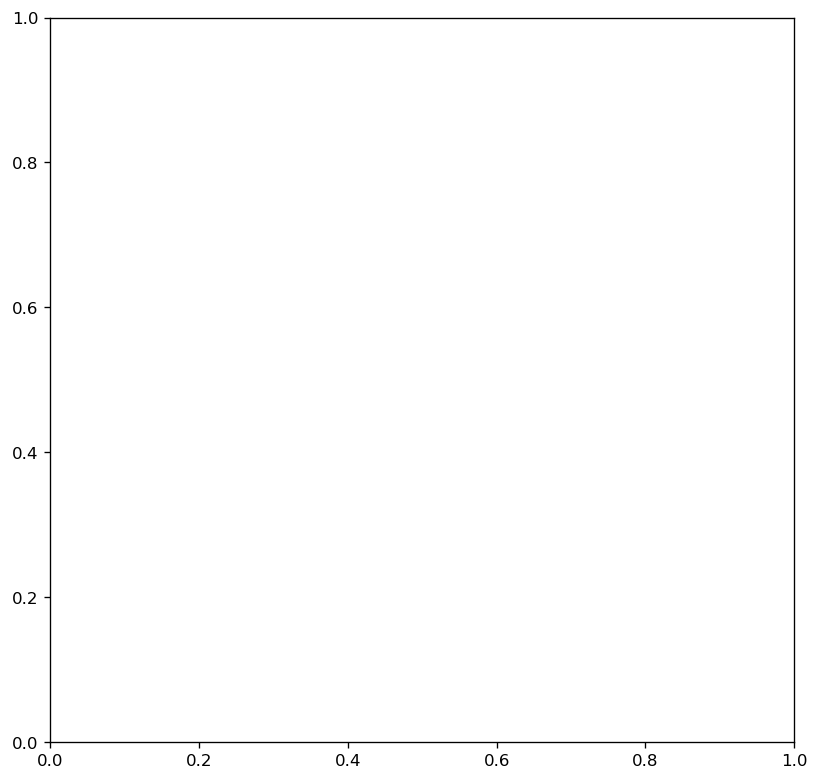

In [3]:
fig = plt.figure(figsize=(8,8),dpi=120);
ax = fig.gca()
h00, = plt.plot(s_,ESS[:,0,0],'gx',label="original coordinates - gibbs");
h01, = plt.plot(s_,ESS[:,1,0],'cx',label="original coordinates - hitandrun");
h10, = plt.plot(s_,ESS[:,2,0],'bx',label="original coordinates - hmc");
h11, = plt.plot(s_,ESS[:,3,0],'rx',label="original coordinates - rejection");
h20, = plt.plot(s_,ESS[:,0,1],'g+',label="rotated coordinates - gibbs");
h21, = plt.plot(s_,ESS[:,1,1],'c+',label="rotated coordinates - hitandrun");
h30, = plt.plot(s_,ESS[:,2,1],'b+',label="rotated coordinates - hmc");
h31, = plt.plot(s_,ESS[:,3,1],'r+',label="rotated coordinates - rejection");
plt.legend(handles=[h00,h01,h10,h11,h20,h21,h30,h31]);
ax.set_xlabel('Mode position', fontsize=16)
ax.set_ylabel('ESS: effective sample size', fontsize=16);


#### Effect of mode shift

Shifting the untruncated mode outside of the feasible region (left side of graph) has dramatic effects. For example, the  rejection sampler cannot deliver any positive sample within a set of 100 million trials when the mode is positioned at -1 or below. The other samplers are more robust to this. The HMC sampler is more robust in general, irrespective of rotation, delivering around 2000 effective samples among the series of 10,000 samples in the worst case and around 4000 on the extreme left. It is a bit odd to see some sort of sour spot around the mode position at -0.75. I do not have a simple explanation for this phenomenon, other than the fact than inequality constraints lead to nonlinear effects. The Gibbs sampler, when used in the rotated coordinate system, delivers an ESS of 7000.

#### Effect of sampler

On the right side of the plot, it appears that the rejection sampler, the HMC sampler, and the Gibbs sampler after rotation all deliver approximately the same ESS which hovers around 10000. It is a bit counter-intutive that the values rise above 10000 but it should be considered that the ESS value is an estimate of course. On the left side, one can see that the HMC sampler is better than the hit-and-run sampler and the rejection sampler. The Gibbs sampler is even better when the coordinate system is rotated.

#### Effect of rotation
One can see that rotating the coordinate systems increases the ESS quite dramatically for the Gibbs sampler. The ESS of every other sampler appears largely unaffected by rotation. 

### Effective sample size and computational efficiency

To evaluate the combined effect of autocorrelation and computational efficiency, the next plot show the ESS divided by the time needed to obtain this number of samples. Let's call this the efficiency. This gives an indication of the overall performance of our sampler: how many effective samples can we get per time unit?

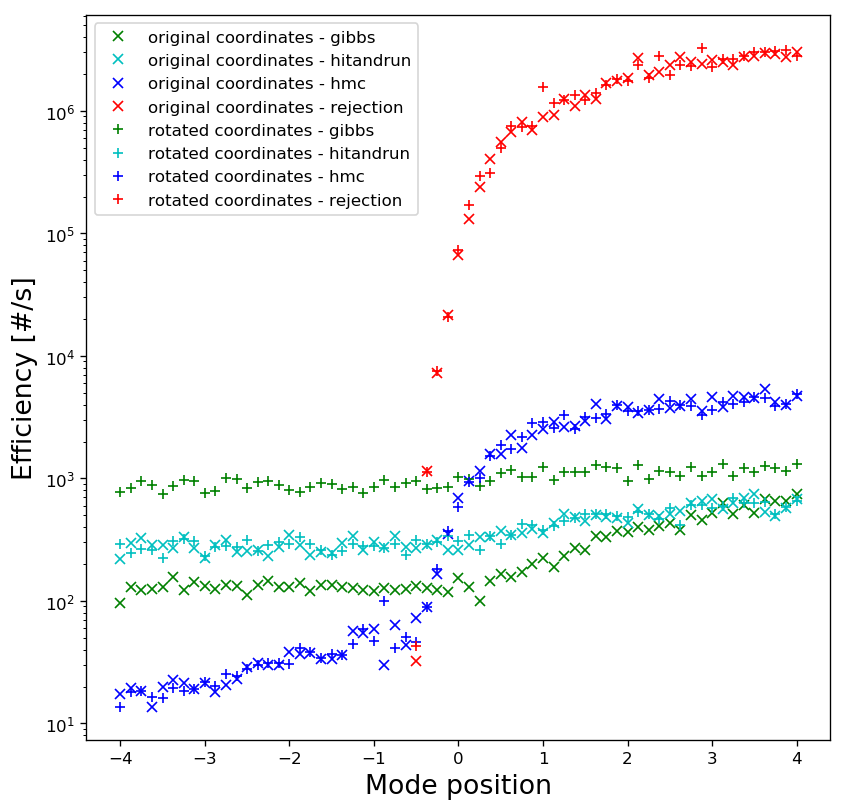

In [14]:
fig = plt.figure(figsize=(8,8),dpi=120);
ax = fig.gca()
h00, = plt.plot(s_,ESS[:,0,0]/lapse[:,0,0],'gx',label="original coordinates - gibbs");
h01, = plt.plot(s_,ESS[:,1,0]/lapse[:,1,0],'cx',label="original coordinates - hitandrun");
h10, = plt.plot(s_,ESS[:,2,0]/lapse[:,2,0],'bx',label="original coordinates - hmc");
h11, = plt.plot(s_,ESS[:,3,0]/lapse[:,3,0],'rx',label="original coordinates - rejection");
h20, = plt.plot(s_,ESS[:,0,1]/lapse[:,0,1],'g+',label="rotated coordinates - gibbs");
h21, = plt.plot(s_,ESS[:,1,1]/lapse[:,1,1],'c+',label="rotated coordinates - hitandrun");
h30, = plt.plot(s_,ESS[:,2,1]/lapse[:,2,1],'b+',label="rotated coordinates - hmc");
h31, = plt.plot(s_,ESS[:,3,1]/lapse[:,3,1],'r+',label="rotated coordinates - rejection");
plt.legend(handles=[h00,h01,h10,h11,h20,h21,h30,h31]);
ax.set_yscale('log')
ax.set_xlabel('Mode position', fontsize=16)
ax.set_ylabel('Efficiency [#/s]', fontsize=16);


#### Effect of mode shift

Shifting the untruncated mode outside of the feasible region (left side of graph) has an increasing effect on the efficiency for values ranging from just about 0 effective samples per second to over 10 million samples per second for the rejection sampler. The effect is less pronounced for the other samplers. This is the strength of these MCMC samplers: they will always deliver a non-zero efficiency. It is somewhat surprising that the effect is still quite pronounced for the HMC sampler, owing to the reduced computational efficiency for mode positions outside the feasible region (left-side of graph). In contrast, the Gibbs sampler and the hit-and-run sampler are more robust to this effect, delivering at least 100 effective samples per second in all cases.

#### Effect of sampler

There is not a single sampler which performs best across the tested cases. For mode positions outside of the feasible region (left), the Gibbs sampler is best if rotation is applied. Otherwise, the hit-and-run sampler is most efficient (right). When the mode is inside the feasible region, the rejection sampler is the most efficient. It is somewhat surprising that HMC is never the optimal sampler. The hit-and-run sampler appears to deliver a reasonable performance (around 500 samples per second) regardless of the mode position and the applied rotation.

#### Effect of rotation
One can see that rotating the coordinate systems increases the efficiency with a factor of 10 for the Gibbs sampler. The ESS of every other sampler appears unaffected by rotation. 

### Take home message

* To evaluate the overall efficiency of the samplers one can combine the effective sample size (ESS) with the computational requirements

* The best sampler depends quite strongly on the density that is sampled and whether rotation is applied. In the studied case, the best sampler is either a Gibbs sampler (requiring adequate rotation) or the rejection sampler. If rotation is not an option, then the hit-and-run sampler seems like a good bet

* It is a bit surprising that the HMC sampler never appears to be the best sampler for the studied case, despite its sophistication. It is likely however, that this depends on the software implementation of this sampler.

### References

[1] Vats, D., Flegal, J. M., & Jones, G. L. (2015). Multivariate output analysis for Markov chain Monte Carlo. [[preprint]](https://arxiv.org/abs/1512.07713).

[2] [[MCMCSE package]](https://cran.r-project.org/web/packages/mcmcse/index.html) 